<a href="https://colab.research.google.com/github/SiHanWang2Developer/data/blob/master/PPlgq40000%2B5000%2B5000%2B5000_b8_lr0_0000005.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detectron2 Beginner's Tutorial

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to detectron2! This is the official colab tutorial of detectron2. Here, we will go through some basics usage of detectron2, including the following:
* Run inference on images or videos, with an existing detectron2 model
* Train a detectron2 model on a new dataset

You can make a copy of this tutorial by "File -> Open in playground mode" and play with it yourself. __DO NOT__ request access to this tutorial.


# Install detectron2

In [3]:
!/opt/bin/nvidia-smi

Tue Jun 30 01:43:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

In [5]:
# # install detectron2:
# !pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html


In [ ]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
# clone the repo to access PointRend code. Use the same version as the installed detectron2
!git clone --branch v0.1.3 https://github.com/facebookresearch/detectron2 detectron2_repo

In [7]:
# # You may need to restart your runtime prior to this, to let your installation take effect
# # Some basic setup:
# # Setup detectron2 logger
# import detectron2
# from detectron2.utils.logger import setup_logger
# setup_logger()

# # import some common libraries
# import numpy as np
# import cv2
import random
# from google.colab.patches import cv2_imshow

# # import some common detectron2 utilities
# from detectron2 import model_zoo
# from detectron2.engine import DefaultPredictor
# from detectron2.config import get_cfg
# from detectron2.utils.visualizer import Visualizer
# from detectron2.data import MetadataCatalog

In [8]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import torch
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog
coco_metadata = MetadataCatalog.get("coco_2017_val")

# import PointRend project
import sys; sys.path.insert(1, "detectron2_repo/projects/PointRend")
import point_rend

# Train on a custom dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the balloon segmentation dataset](https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon)
which only has one class: balloon.
We'll train a balloon segmentation model from an existing model pre-trained on COCO dataset, available in detectron2's model zoo.

Note that COCO dataset does not have the "balloon" category. We'll be able to recognize this new class in a few minutes.

## Prepare the dataset

In [9]:
#加载谷歌云盘 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
#注册数据集
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog
register_coco_instances("train", {}, "./drive/My Drive/dataset/train/train.json", "./drive/My Drive/dataset/train/imgs")
LGQmetadata = MetadataCatalog.get("train")
LGQdataset_dicts = DatasetCatalog.get("train")

[06/30 01:46:30 d2.data.datasets.coco]: Loading ./drive/My Drive/dataset/train/train.json takes 1.22 seconds.
[06/30 01:46:30 d2.data.datasets.coco]: Loaded 611 images in COCO format from ./drive/My Drive/dataset/train/train.json


Register the balloon dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. See the tutorial for more details.


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



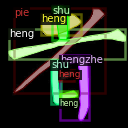

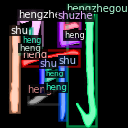

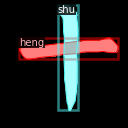

In [11]:
# dataset_dicts = get_balloon_dicts("balloon/train")
for d in random.sample(LGQdataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], LGQmetadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

## Train!

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU, or ~2 minutes on a P100 GPU.


In [33]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()

#加入pointrend结构
# Add PointRend-specific config
point_rend.add_pointrend_config(cfg)



# cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.merge_from_file("/content/detectron2_repo/projects/PointRend/configs/InstanceSegmentation/pointrend_rcnn_R_50_FPN_3x_coco.yaml")


cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 4
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
# cfg.MODEL.WEIGHTS = "https://dl.fbaipublicfiles.com/detectron2/PointRend/InstanceSegmentation/pointrend_rcnn_R_50_FPN_3x_coco/164955410/model_final_3c3198.pkl"  # Let training initialize from model zoo
cfg.MODEL.WEIGHTS = "/content/drive/My Drive/PPlgq40000+5000+5000-b8-lr0.0001/model_final.pth"
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.0000005  # pick a good LR
cfg.SOLVER.MAX_ITER = 5000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 25  # only has one class (ballon)
cfg.MODEL.POINT_HEAD.NUM_CLASSES = 25 #修改POINT_HEAD.NUM_CLASSES 32 默认值为80


cfg.DATASETS.TRAIN = ("train",)
# cfg.OUTPUT_DIR = 'PPlgq40000-b8-lr0.000125'
# cfg.OUTPUT_DIR = 'PPlgq40000+10000-b8-lr0.0001'
# cfg.OUTPUT_DIR = 'PPlgq40000+5000+5000-b8-lr0.0001'
cfg.OUTPUT_DIR = '/content/drive/My Drive/PPlgq40000+5000+5000+5000-b8-lr0.0000005'

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[06/30 11:32:14 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [34]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir  '/content/drive/My Drive/PPlgq40000+5000+5000+5000-b8-lr0.0000005'


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<IPython.core.display.Javascript object>

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [ ]:
#注册数据集
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog
register_coco_instances("val", {}, "./drive/My Drive/dataset/val/val.json", "./drive/My Drive/dataset/val/imgs")
metadata = MetadataCatalog.get("val")
dataset_dicts = DatasetCatalog.get("val")

In [38]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
# cfg.OUTPUT_DIR = '/content/drive/My Drive/PPlgq40000+5000+5000+5000-b8-lr0.0000005'

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("val", )
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

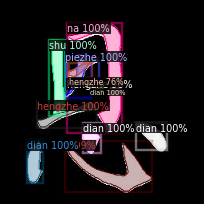

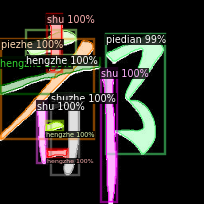

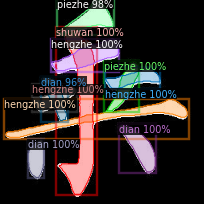

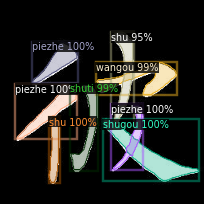

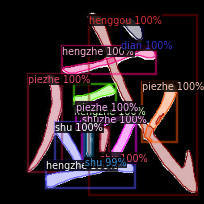

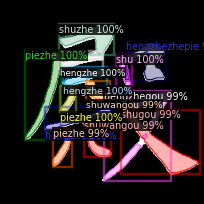

In [39]:
from detectron2.utils.visualizer import ColorMode
# dataset_dicts = get_balloon_dicts("balloon/val")
for d in random.sample(dataset_dicts, 6):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~70%. Not bad!

In [40]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "val")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

[06/30 13:01:41 d2.data.datasets.coco]: Loaded 35 images in COCO format from ./drive/My Drive/dataset/val/val.json
[06/30 13:01:41 d2.data.common]: Serializing 35 elements to byte tensors and concatenating them all ...
[06/30 13:01:41 d2.data.common]: Serialized dataset takes 0.17 MiB
[06/30 13:01:41 d2.evaluation.evaluator]: Start inference on 35 images
[06/30 13:01:42 d2.evaluation.evaluator]: Inference done 11/35. 0.0706 s / img. ETA=0:00:01
[06/30 13:01:44 d2.evaluation.evaluator]: Total inference time: 0:00:02.329835 (0.077661 s / img per device, on 1 devices)
[06/30 13:01:44 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.069335 s / img per device, on 1 devices)
[06/30 13:01:44 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/30 13:01:44 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[06/30 13:01:44 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
DO

OrderedDict([('bbox',
              {'AP': 6.747235183000652,
               'AP-dian': 77.64590844221561,
               'AP-heng': 0.0,
               'AP-henggou': 0.0,
               'AP-hengpie': 0.0,
               'AP-hengpiewangou': 12.623762376237623,
               'AP-hengxiegou': 0.0,
               'AP-hengzhe': 0.034944670937682,
               'AP-hengzhegou': 0.0,
               'AP-hengzhezhe': 0.0,
               'AP-hengzhezhepie': 0.0,
               'AP-na': 0.19801980198019803,
               'AP-pie': 0.0,
               'AP-piedian': 0.0,
               'AP-piedun': 0.0,
               'AP-piezhe': 0.2009753214127383,
               'AP-shu': 77.97726896223243,
               'AP-shugou': 0.0,
               'AP-shuti': 0.0,
               'AP-shuwan': 0.0,
               'AP-shuwangou': 0.0,
               'AP-shuzhe': 0.0,
               'AP-ti': 0.0,
               'AP-wangou': 0.0,
               'AP-wogou': 0.0,
               'AP-xiegou': 0.0,
            

In [41]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("train", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "train")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

[06/30 13:01:53 d2.data.datasets.coco]: Loaded 611 images in COCO format from ./drive/My Drive/dataset/train/train.json
[06/30 13:01:53 d2.data.common]: Serializing 611 elements to byte tensors and concatenating them all ...
[06/30 13:01:53 d2.data.common]: Serialized dataset takes 3.33 MiB
[06/30 13:01:53 d2.evaluation.evaluator]: Start inference on 611 images
[06/30 13:01:54 d2.evaluation.evaluator]: Inference done 11/611. 0.0676 s / img. ETA=0:00:43
[06/30 13:01:59 d2.evaluation.evaluator]: Inference done 80/611. 0.0685 s / img. ETA=0:00:38
[06/30 13:02:04 d2.evaluation.evaluator]: Inference done 151/611. 0.0681 s / img. ETA=0:00:33
[06/30 13:02:09 d2.evaluation.evaluator]: Inference done 221/611. 0.0681 s / img. ETA=0:00:28
[06/30 13:02:14 d2.evaluation.evaluator]: Inference done 291/611. 0.0681 s / img. ETA=0:00:23
[06/30 13:02:19 d2.evaluation.evaluator]: Inference done 361/611. 0.0681 s / img. ETA=0:00:17
[06/30 13:02:24 d2.evaluation.evaluator]: Inference done 432/611. 0.0679 s

OrderedDict([('bbox',
              {'AP': 92.77708208063619,
               'AP-dian': 88.35767790084324,
               'AP-heng': 88.75413124517344,
               'AP-henggou': 94.33322924107853,
               'AP-hengpie': 93.59218769731977,
               'AP-hengpiewangou': 95.26402640264025,
               'AP-hengxiegou': 100.0,
               'AP-hengzhe': 89.95645177833865,
               'AP-hengzhegou': 96.7157465538011,
               'AP-hengzhezhe': 91.12211221122112,
               'AP-hengzhezhepie': 97.35373537353735,
               'AP-na': 95.13913244537197,
               'AP-pie': 92.90836896146268,
               'AP-piedian': 79.68646864686468,
               'AP-piedun': 90.6996699669967,
               'AP-piezhe': 94.97928979938695,
               'AP-shu': 86.82333011669294,
               'AP-shugou': 90.42638101015324,
               'AP-shuti': 98.56872451951078,
               'AP-shuwan': 90.64708151487419,
               'AP-shuwangou': 95.5143014301

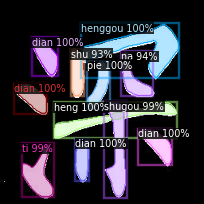

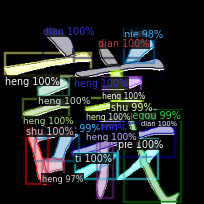

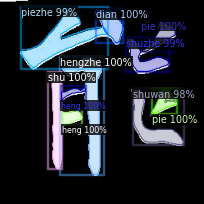

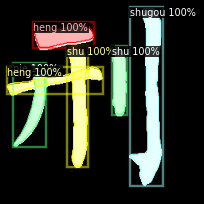

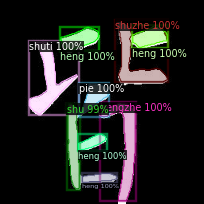

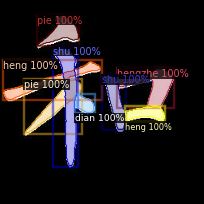

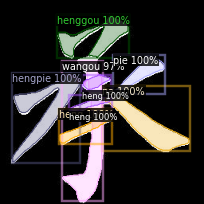

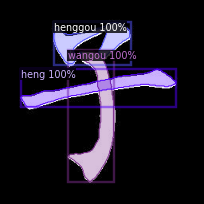

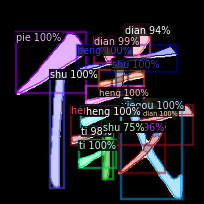

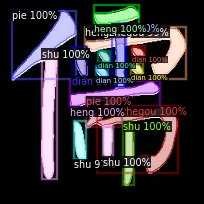

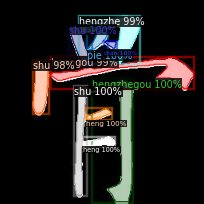

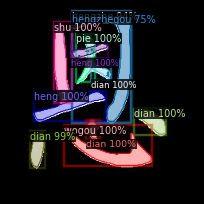

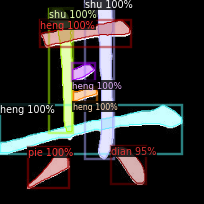

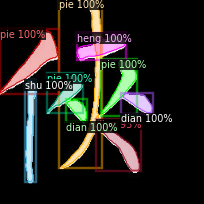

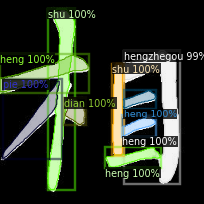

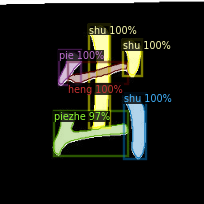

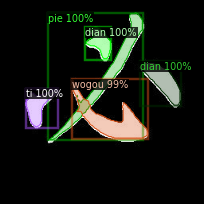

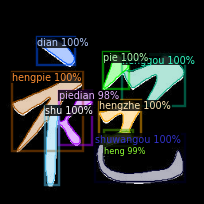

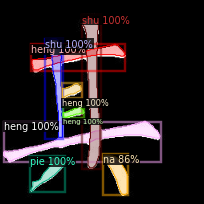

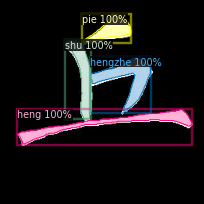

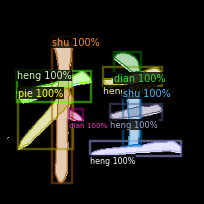

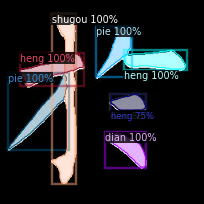

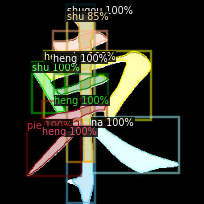

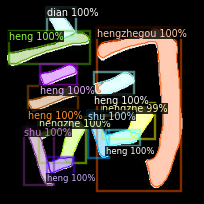

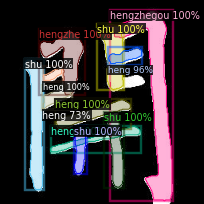

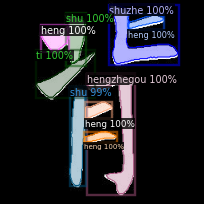

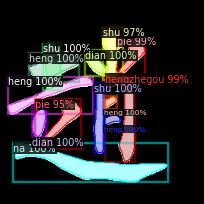

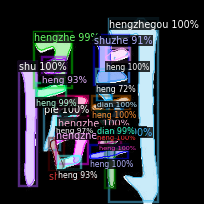

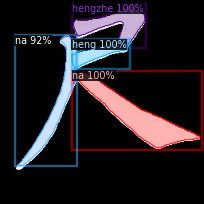

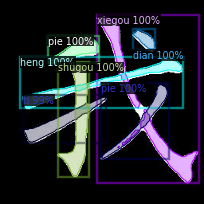

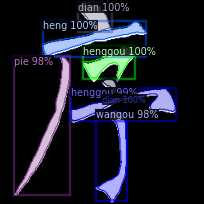

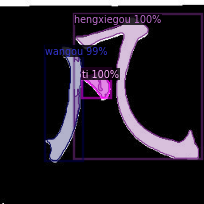

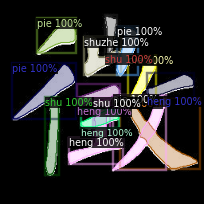

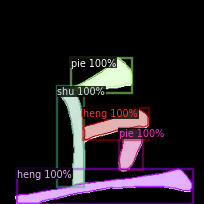

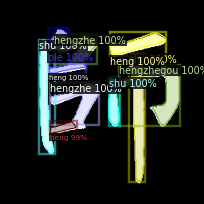

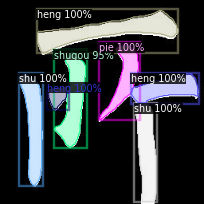

In [43]:
from detectron2.utils.visualizer import ColorMode
# dataset_dicts = get_balloon_dicts("balloon/val")
for d in random.sample(LGQdataset_dicts, 36):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=LGQmetadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])